# Tema: ¿Es posible ahorrar en calefacción (o aire acondicionado)?

## Premisas:  
    • El sistema HVAC es eléctrico  
    • Tenemos tarifa eléctrica con discriminación horaria  
    • Queremos la temperatura de consigna en un horario determinado (no de forma continua)  

La idea es usar la estancia que vamos a acondicionar como una ‘batería térmica’, calentándola (o enfriándola) a las horas en que resulte más barata la energía consumida, excediendo la temperatura de consigna si es necesario.
El sistema será tanto más eficaz cuanto mayor sea la diferencia de precio entre las distintas horas, y cuanto mejor aislada esté la estancia.
Conviene tener en cuenta que la energía consumida aumentará, se trata de minimizar el coste, no el consumo.

Este es un estudio preliminar para, posteriormente, generar un modelo de machine learning que indique la forma más barata de acondicionar el local.

In [59]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

## Obtención de datos  
Para realizar este EDA cuento con datos obtenidos durante un año en una estancia que, durante el período de estudio, se ha calentado únicamente por medio de una bomba de calor con un COP entre 3.0 y 3.5.  
Los datos se ha recogido por medio de la aplicación Home Assistant, y se han almacenado en una base de datos InfluxDB, de dónde se han extraído a un csv por medio de las consultas pertinentes.

In [60]:
todo = pd.read_csv('./Everything for a year 01.csv')

In [61]:
# Vistazo preliminar a los datos
todo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105120 entries, 0 to 105119
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time              105120 non-null  object 
 1   kWh.mean_value    15396 non-null   float64
 2   kWh.mean_value_2  35357 non-null   float64
 3   °C.mean_value     8478 non-null    float64
 4   °C.mean_value_2   27898 non-null   float64
 5   €/kWh.mean_value  9235 non-null    float64
dtypes: float64(5), object(1)
memory usage: 4.8+ MB


In [62]:
todo.head(10)

,time,kWh.mean_value,kWh.mean_value_2,°C.mean_value,°C.mean_value_2,€/kWh.mean_value
0,2022-10-15T00:00:00.000+02:00,NaN,NaN,NaN,23.7,0.24978
1,2022-10-15T00:05:00.000+02:00,NaN,NaN,NaN,NaN,NaN
2,2022-10-15T00:10:00.000+02:00,NaN,NaN,NaN,NaN,NaN
3,2022-10-15T00:15:00.000+02:00,NaN,NaN,NaN,23.8,NaN
4,2022-10-15T00:20:00.000+02:00,NaN,NaN,NaN,NaN,NaN
5,2022-10-15T00:25:00.000+02:00,NaN,NaN,18.6,NaN,NaN
6,2022-10-15T00:30:00.000+02:00,NaN,NaN,NaN,23.7,NaN
7,2022-10-15T00:35:00.000+02:00,NaN,NaN,NaN,NaN,NaN
8,2022-10-15T00:40:00.000+02:00,NaN,NaN,NaN,NaN,NaN
9,2022-10-15T00:45:00.000+02:00,NaN,NaN,NaN,23.6,NaN


### Significado de las columnas  
 - time contiene la información del momento en que se recogen los datos
 - kWh.mean_value y kWh.mean_value_2 representan el consumo del sistema de calefacción. Está dividido en dos columnas porque se ha recogido con dos sensores distintos, de forma sucesiva (el segundo sensor sustituyó al primero).  
 - °C.mean_value representa la temperatura exterior, recogida de la API de AEMET. Éste dato se recoge una vez por hora.
 - °C.mean_value_2 representa la temperatura interior, y se recoge con distintos períodos, o bien cada vez que cambia más de dos décimas de grado.
 - €/kWh.mean_value representa el precio de la electricidad, se recoge una vez por hora, y no cambia durante cada hora.

## Limpieza de datos  
Podemos observar que hay gran cantidad de valores nulos, en todas las columnas.  
Ésto se debe a la frecuencia de muestreo de los datos (5 min.), que es inferior a la de algunos de los datos (1 h., o frecuencias variables).  
Podemos reemplazar estos valores nulos por otros válidos empleando técnicas diferentes según la columna de que se trate.

C mean value es la temperatura exterior ==> interpolar linealmente entre valores  
C mean value 2 es la temperatura interior  
€/kWh rellenar nulos con valor anterior

La temperatura exterior se recoge una vez por hora, así que una aproximación válida sería interpolar linealmente entre valores existentes para reponer los faltantes.

In [63]:
todo['°C.mean_value'].interpolate(method='linear', limit_direction='forward', axis = 0, inplace=True)

In [64]:
todo.head(10)

,time,kWh.mean_value,kWh.mean_value_2,°C.mean_value,°C.mean_value_2,€/kWh.mean_value
0,2022-10-15T00:00:00.000+02:00,NaN,NaN,NaN,23.7,0.24978
1,2022-10-15T00:05:00.000+02:00,NaN,NaN,NaN,NaN,NaN
2,2022-10-15T00:10:00.000+02:00,NaN,NaN,NaN,NaN,NaN
3,2022-10-15T00:15:00.000+02:00,NaN,NaN,NaN,23.8,NaN
4,2022-10-15T00:20:00.000+02:00,NaN,NaN,NaN,NaN,NaN
5,2022-10-15T00:25:00.000+02:00,NaN,NaN,18.600000,NaN,NaN
6,2022-10-15T00:30:00.000+02:00,NaN,NaN,18.483333,23.7,NaN
7,2022-10-15T00:35:00.000+02:00,NaN,NaN,18.366667,NaN,NaN
8,2022-10-15T00:40:00.000+02:00,NaN,NaN,18.250000,NaN,NaN
9,2022-10-15T00:45:00.000+02:00,NaN,NaN,18.133333,23.6,NaN


En la columna €/kWh.mean_value, podemos rellenar nulos con el valor anterior, dado que este dato sólo cambia una vez por hora.

In [65]:
todo['€/kWh.mean_value'].ffill(axis = 0, inplace= True)

In [66]:
todo.head(10)

,time,kWh.mean_value,kWh.mean_value_2,°C.mean_value,°C.mean_value_2,€/kWh.mean_value
0,2022-10-15T00:00:00.000+02:00,NaN,NaN,NaN,23.7,0.24978
1,2022-10-15T00:05:00.000+02:00,NaN,NaN,NaN,NaN,0.24978
2,2022-10-15T00:10:00.000+02:00,NaN,NaN,NaN,NaN,0.24978
3,2022-10-15T00:15:00.000+02:00,NaN,NaN,NaN,23.8,0.24978
4,2022-10-15T00:20:00.000+02:00,NaN,NaN,NaN,NaN,0.24978
5,2022-10-15T00:25:00.000+02:00,NaN,NaN,18.600000,NaN,0.24978
6,2022-10-15T00:30:00.000+02:00,NaN,NaN,18.483333,23.7,0.24978
7,2022-10-15T00:35:00.000+02:00,NaN,NaN,18.366667,NaN,0.24978
8,2022-10-15T00:40:00.000+02:00,NaN,NaN,18.250000,NaN,0.24978
9,2022-10-15T00:45:00.000+02:00,NaN,NaN,18.133333,23.6,0.24978


ºC_mean_value_2 es la temperatura interior, y los huecos representan momentos en que la temperatura no ha cambiado, y por tanto podemos sustituirlos por el valor anterior.

In [67]:
todo['°C.mean_value_2'].ffill(axis= 0, inplace= True)

In [68]:
todo.head(10)

,time,kWh.mean_value,kWh.mean_value_2,°C.mean_value,°C.mean_value_2,€/kWh.mean_value
0,2022-10-15T00:00:00.000+02:00,NaN,NaN,NaN,23.7,0.24978
1,2022-10-15T00:05:00.000+02:00,NaN,NaN,NaN,23.7,0.24978
2,2022-10-15T00:10:00.000+02:00,NaN,NaN,NaN,23.7,0.24978
3,2022-10-15T00:15:00.000+02:00,NaN,NaN,NaN,23.8,0.24978
4,2022-10-15T00:20:00.000+02:00,NaN,NaN,NaN,23.8,0.24978
5,2022-10-15T00:25:00.000+02:00,NaN,NaN,18.600000,23.8,0.24978
6,2022-10-15T00:30:00.000+02:00,NaN,NaN,18.483333,23.7,0.24978
7,2022-10-15T00:35:00.000+02:00,NaN,NaN,18.366667,23.7,0.24978
8,2022-10-15T00:40:00.000+02:00,NaN,NaN,18.250000,23.7,0.24978
9,2022-10-15T00:45:00.000+02:00,NaN,NaN,18.133333,23.6,0.24978


In [69]:
todo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105120 entries, 0 to 105119
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time              105120 non-null  object 
 1   kWh.mean_value    15396 non-null   float64
 2   kWh.mean_value_2  35357 non-null   float64
 3   °C.mean_value     105115 non-null  float64
 4   °C.mean_value_2   105120 non-null  float64
 5   €/kWh.mean_value  105120 non-null  float64
dtypes: float64(5), object(1)
memory usage: 4.8+ MB


La columna time no contiene valores nulos, pero no está en el formato más útil. Podemos mejorarla pasándola a datetime, que luego nos permite hacer mejor búsqueda y filtrado.

In [70]:
todo['time'] = pd.to_datetime(todo['time'], format='%Y-%m-%dT%H:%M:%S.%f%z', utc= True)

In [71]:
todo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105120 entries, 0 to 105119
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   time              105120 non-null  datetime64[ns, UTC]
 1   kWh.mean_value    15396 non-null   float64            
 2   kWh.mean_value_2  35357 non-null   float64            
 3   °C.mean_value     105115 non-null  float64            
 4   °C.mean_value_2   105120 non-null  float64            
 5   €/kWh.mean_value  105120 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5)
memory usage: 4.8 MB


Para el análisis que queremos hacer no es necesario el dataset entero. Voy a seleccionar únicamente el mes de enero, pues contiene toda la información necesaria. Para ello voy a utilizar las posibilidades que brinda el tener la columna time en formato datatime. 

In [72]:
enero = todo.copy()[todo['time'].dt.month == 1]

In [73]:
enero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 22488 to 31415
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   time              8928 non-null   datetime64[ns, UTC]
 1   kWh.mean_value    3667 non-null   float64            
 2   kWh.mean_value_2  0 non-null      float64            
 3   °C.mean_value     8928 non-null   float64            
 4   °C.mean_value_2   8928 non-null   float64            
 5   €/kWh.mean_value  8928 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(5)
memory usage: 488.2 KB


Durante este período todos los datos de consumo están recogidos en el primer sensor, así que podemos prescindir de la columna kWh.mean_value_2.

In [74]:
enero.drop(columns= ['kWh.mean_value_2'], axis= 1, inplace= True)

En la columna de consumo (kWh.mean_value) hay algunos valores nulos, que podemos completar con interpolación lineal, dado que esta columna es siempre incremental.

In [75]:
enero['kWh.mean_value'].interpolate(method='linear', limit_direction='forward', axis = 0, inplace=True)

enero

,time,kWh.mean_value,°C.mean_value,°C.mean_value_2,€/kWh.mean_value
22488,2023-01-01 00:00:00+00:00,NaN,20.850000,20.6,0.04301
22489,2023-01-01 00:05:00+00:00,NaN,20.825000,20.4,0.04301
22490,2023-01-01 00:10:00+00:00,NaN,20.800000,20.4,0.04301
22491,2023-01-01 00:15:00+00:00,NaN,20.775000,20.4,0.04301
22492,2023-01-01 00:20:00+00:00,758.31,20.750000,20.3,0.04301
...,...,...,...,...,...
31411,2023-01-31 23:35:00+00:00,911.90,8.183333,19.4,0.17975
31412,2023-01-31 23:40:00+00:00,911.90,8.175000,19.4,0.17975
31413,2023-01-31 23:45:00+00:00,911.90,8.166667,19.1,0.17975
31414,2023-01-31 23:50:00+00:00,911.90,8.158333,19.1,0.17975


Hay algunos datos que no aparecen en el dataset, pero pueden obtenerse a partir del mismo.  
Uno de ellos es el consumo eléctrico, en kWh, en cada período, el cual puede obtenerse como diferencia entre dos valores consecutivos de kWh.mean_value.

In [76]:
enero['consumo'] = enero['kWh.mean_value'].diff()

enero.head(10)

,time,kWh.mean_value,°C.mean_value,°C.mean_value_2,€/kWh.mean_value,consumo
22488,2023-01-01 00:00:00+00:00,NaN,20.850000,20.6,0.04301,NaN
22489,2023-01-01 00:05:00+00:00,NaN,20.825000,20.4,0.04301,NaN
22490,2023-01-01 00:10:00+00:00,NaN,20.800000,20.4,0.04301,NaN
22491,2023-01-01 00:15:00+00:00,NaN,20.775000,20.4,0.04301,NaN
22492,2023-01-01 00:20:00+00:00,758.310000,20.750000,20.3,0.04301,NaN
22493,2023-01-01 00:25:00+00:00,758.311667,20.725000,20.3,0.04301,0.001667
22494,2023-01-01 00:30:00+00:00,758.313333,20.700000,20.3,0.04301,0.001667
22495,2023-01-01 00:35:00+00:00,758.315000,20.666667,20.2,0.04301,0.001667
22496,2023-01-01 00:40:00+00:00,758.316667,20.633333,20.2,0.04301,0.001667
22497,2023-01-01 00:45:00+00:00,758.318333,20.600000,20.2,0.04301,0.001667


Otro valor útil es la diferencia de temperatura entre el interior y el exterior, que llamaremos delta_temp.

In [77]:
enero['delta_temp'] = enero['°C.mean_value_2'] - enero['°C.mean_value']

enero.head(10)

,time,kWh.mean_value,°C.mean_value,°C.mean_value_2,€/kWh.mean_value,consumo,delta_temp
22488,2023-01-01 00:00:00+00:00,NaN,20.850000,20.6,0.04301,NaN,-0.250000
22489,2023-01-01 00:05:00+00:00,NaN,20.825000,20.4,0.04301,NaN,-0.425000
22490,2023-01-01 00:10:00+00:00,NaN,20.800000,20.4,0.04301,NaN,-0.400000
22491,2023-01-01 00:15:00+00:00,NaN,20.775000,20.4,0.04301,NaN,-0.375000
22492,2023-01-01 00:20:00+00:00,758.310000,20.750000,20.3,0.04301,NaN,-0.450000
22493,2023-01-01 00:25:00+00:00,758.311667,20.725000,20.3,0.04301,0.001667,-0.425000
22494,2023-01-01 00:30:00+00:00,758.313333,20.700000,20.3,0.04301,0.001667,-0.400000
22495,2023-01-01 00:35:00+00:00,758.315000,20.666667,20.2,0.04301,0.001667,-0.466667
22496,2023-01-01 00:40:00+00:00,758.316667,20.633333,20.2,0.04301,0.001667,-0.433333
22497,2023-01-01 00:45:00+00:00,758.318333,20.600000,20.2,0.04301,0.001667,-0.400000


También es útil conocer la velocidad a la que cambia la temperatura interior, que denominaré gradiente_interior, y que es la diferencia entre valores consecutivos de °C.mean_value_2.

In [78]:
enero['gradiente_interior'] = enero['°C.mean_value_2'].diff()

enero.head(10)

,time,kWh.mean_value,°C.mean_value,°C.mean_value_2,€/kWh.mean_value,consumo,delta_temp,gradiente_interior
22488,2023-01-01 00:00:00+00:00,NaN,20.850000,20.6,0.04301,NaN,-0.250000,NaN
22489,2023-01-01 00:05:00+00:00,NaN,20.825000,20.4,0.04301,NaN,-0.425000,-0.2
22490,2023-01-01 00:10:00+00:00,NaN,20.800000,20.4,0.04301,NaN,-0.400000,0.0
22491,2023-01-01 00:15:00+00:00,NaN,20.775000,20.4,0.04301,NaN,-0.375000,0.0
22492,2023-01-01 00:20:00+00:00,758.310000,20.750000,20.3,0.04301,NaN,-0.450000,-0.1
22493,2023-01-01 00:25:00+00:00,758.311667,20.725000,20.3,0.04301,0.001667,-0.425000,0.0
22494,2023-01-01 00:30:00+00:00,758.313333,20.700000,20.3,0.04301,0.001667,-0.400000,0.0
22495,2023-01-01 00:35:00+00:00,758.315000,20.666667,20.2,0.04301,0.001667,-0.466667,-0.1
22496,2023-01-01 00:40:00+00:00,758.316667,20.633333,20.2,0.04301,0.001667,-0.433333,0.0
22497,2023-01-01 00:45:00+00:00,758.318333,20.600000,20.2,0.04301,0.001667,-0.400000,0.0


In [79]:
# enero['€'] = enero['consumo'] * enero['€/kWh.mean_value']

# enero.head(10)

In [80]:
# enero['hora'] = enero['time'].dt.hour
# enero['minuto']

In [81]:
# This is pretty much broken

# for i in range(8):
#     plt.plot(enero['°C.mean_value_2'][enero['time'].dt.day == i], enero['time'][enero['time'].dt.day == i].dt.time);

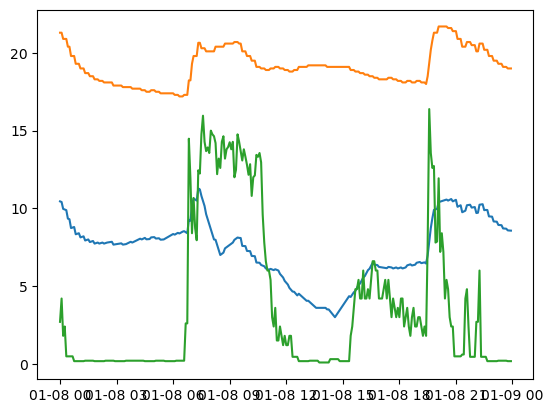

In [82]:
dia_deseado = 8
dia_08 = enero.copy()[enero['time'].dt.day == dia_deseado]

plt.plot(dia_08['time'], dia_08['delta_temp'])
plt.plot(dia_08['time'], dia_08['°C.mean_value_2'])
plt.plot(dia_08['time'], dia_08['consumo']*120);

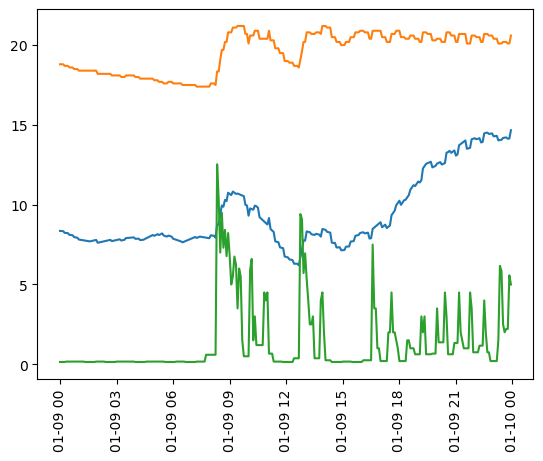

In [83]:
dia_deseado = 9
dia_09 = enero.copy()[enero['time'].dt.day == dia_deseado]

plt.plot(dia_09['time'], dia_09['delta_temp'])
plt.plot(dia_09['time'], dia_09['°C.mean_value_2'])
plt.plot(dia_09['time'], dia_09['consumo']*100)
plt.xticks(rotation = 90);

In [84]:
dia_deseado = 10
dia_10 = enero.copy()[enero['time'].dt.day == dia_deseado]

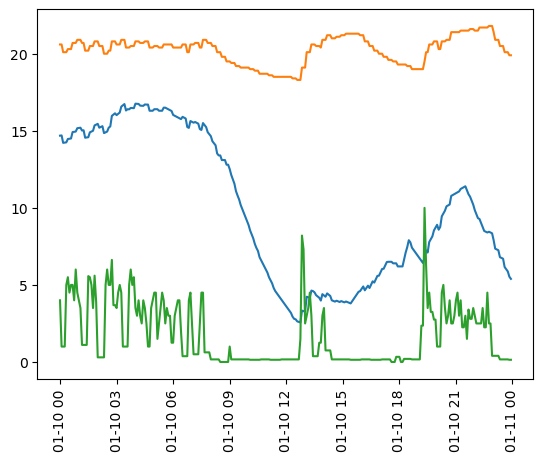

In [85]:
plt.plot(dia_10['time'], dia_10['delta_temp'])
plt.plot(dia_10['time'], dia_10['°C.mean_value_2'])
plt.plot(dia_10['time'], dia_10['consumo']*100)
plt.xticks(rotation = 90);

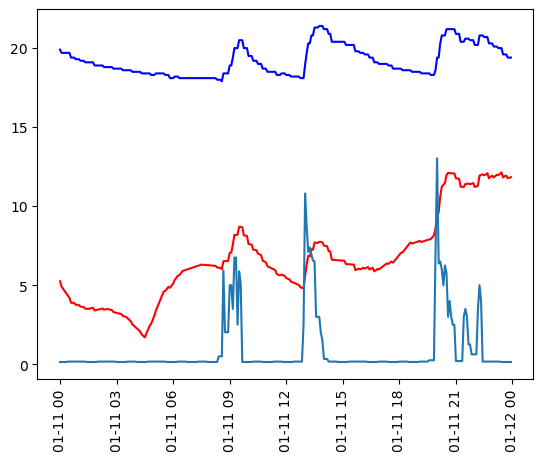

In [86]:
dia_deseado = 11
dia_11 = enero.copy()[enero['time'].dt.day == dia_deseado]

plt.plot(dia_11['time'], dia_11['delta_temp'], color = 'red')
plt.plot(dia_11['time'], dia_11['°C.mean_value_2'], color = 'blue')
plt.plot(dia_11['time'], dia_11['consumo']*100)
plt.xticks(rotation = 90);

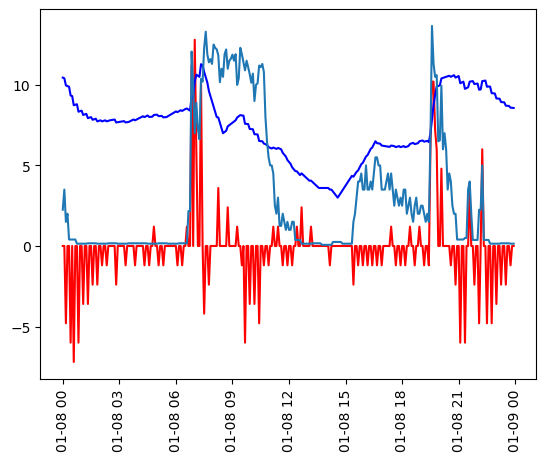

In [87]:

plt.plot(dia_08['time'], dia_08['gradiente_interior']*12, color = 'red')
plt.plot(dia_08['time'], dia_08['delta_temp'],color = 'blue')
plt.plot(dia_08['time'], dia_08['consumo']*100)
plt.xticks(rotation = 90);

## Datos enero con calefacción apagada

In [88]:
enero_heat_off = enero.copy([enero['consumo'] == 0])

enero_heat_off.head()

,time,kWh.mean_value,°C.mean_value,°C.mean_value_2,€/kWh.mean_value,consumo,delta_temp,gradiente_interior
22488,2023-01-01 00:00:00+00:00,NaN,20.850,20.6,0.04301,NaN,-0.250,NaN
22489,2023-01-01 00:05:00+00:00,NaN,20.825,20.4,0.04301,NaN,-0.425,-0.2
22490,2023-01-01 00:10:00+00:00,NaN,20.800,20.4,0.04301,NaN,-0.400,0.0
22491,2023-01-01 00:15:00+00:00,NaN,20.775,20.4,0.04301,NaN,-0.375,0.0
22492,2023-01-01 00:20:00+00:00,758.31,20.750,20.3,0.04301,NaN,-0.450,-0.1


In [89]:
enero_heat_off.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 22488 to 31415
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   time                8928 non-null   datetime64[ns, UTC]
 1   kWh.mean_value      8924 non-null   float64            
 2   °C.mean_value       8928 non-null   float64            
 3   °C.mean_value_2     8928 non-null   float64            
 4   €/kWh.mean_value    8928 non-null   float64            
 5   consumo             8923 non-null   float64            
 6   delta_temp          8928 non-null   float64            
 7   gradiente_interior  8927 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 627.8 KB


## Velocidad de enfriamiento

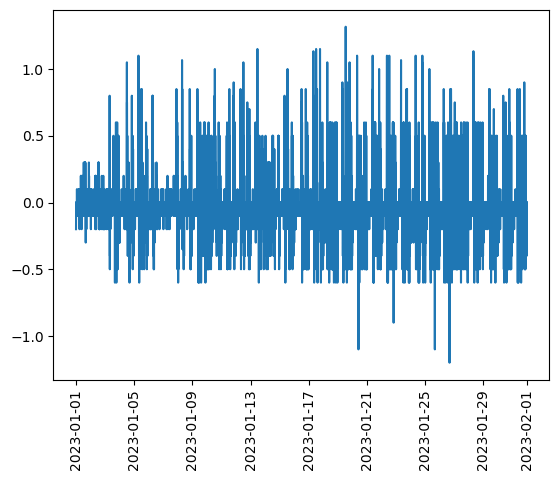

In [90]:
plt.plot(enero_heat_off['time'], enero_heat_off['gradiente_interior'])
plt.xticks(rotation = 90);

In [134]:
delta_large = enero_heat_off[(enero_heat_off['delta_temp'] > 12) & (enero_heat_off['time'].dt.hour >= 1) & (enero_heat_off['time'].dt.hour <= 4)]

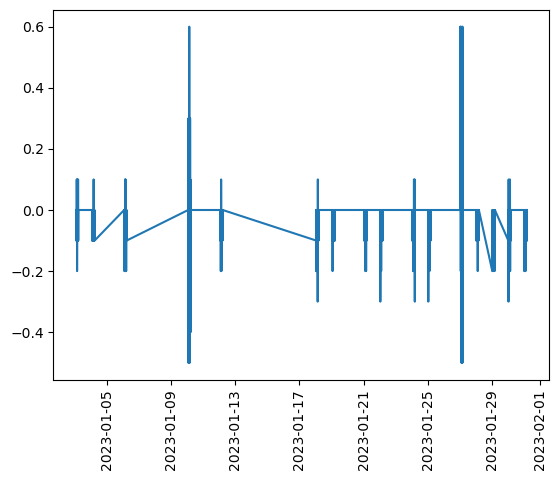

In [135]:
plt.plot(delta_large['time'], delta_large['gradiente_interior'])
plt.xticks(rotation = 90);

In [136]:
# Velocidad, en ºC/h, a la que cambia la temp. interior, para delta > 12 y de noche
# Éste debería ser el caso más desfavorable
delta_large['gradiente_interior'][delta_large['gradiente_interior'] < 0].mean()* 12

-1.8281879194630868

In [93]:
# Temp. exterior media en enero
enero['°C.mean_value'].mean()

8.403337813620071

In [94]:
# Temp. exterior media en enero entre las 17 y las 00
enero['°C.mean_value'][enero['time'].dt.hour > 14].mean()

8.867495838641817

In [96]:
# Los días 9 y 10 hice ensayo para ver cuánto cuesta mantener temperatura
# en el interior cuando la exterior es baja (delta > 10)
caso_estudio = enero[(enero['time'].dt.day > 8) & (enero['time'].dt.day < 11)]

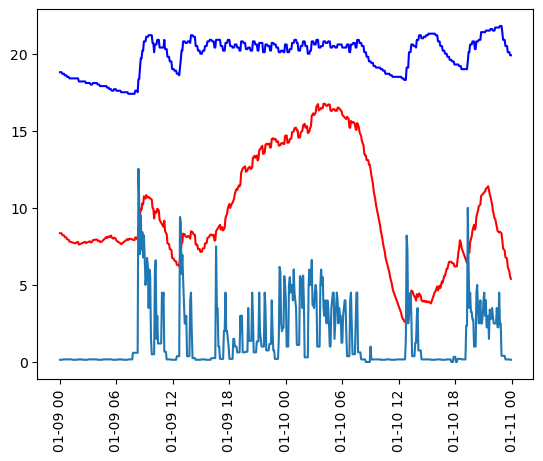

In [97]:
plt.plot(caso_estudio['time'], caso_estudio['delta_temp'], color = 'red')
plt.plot(caso_estudio['time'], caso_estudio['°C.mean_value_2'], color = 'blue')
plt.plot(caso_estudio['time'], caso_estudio['consumo']*100)
plt.xticks(rotation = 90);

In [98]:
# De este caso de estudio es interesante el período entre las 18 y las 6
consumo_estable = caso_estudio[(caso_estudio['time'] >= '2023-01-09 18:00') & (caso_estudio['time'] <= '2023-01-10 06:00')]

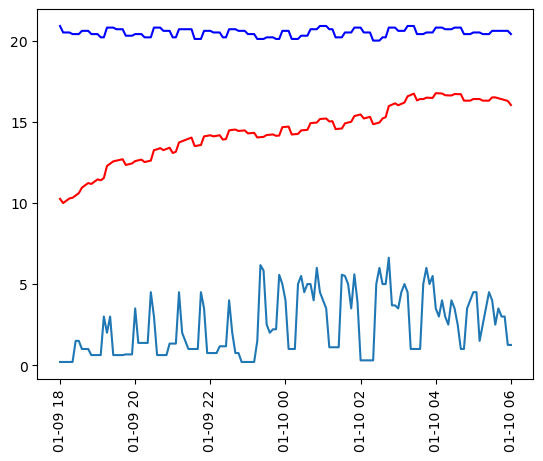

In [99]:
plt.plot(consumo_estable['time'], consumo_estable['delta_temp'], color = 'red')
plt.plot(consumo_estable['time'], consumo_estable['°C.mean_value_2'], color = 'blue')
plt.plot(consumo_estable['time'], consumo_estable['consumo']*100)
plt.xticks(rotation = 90);

In [100]:
# temperatura media de la estancia
consumo_estable['°C.mean_value_2'].mean()

20.5

In [101]:
# diferencia media de temperatura con el exterior
consumo_estable['delta_temp'].mean()

14.375603448275863

In [102]:
# 
consumo_estable['consumo'].mean()*12

0.29379310344828147

## Precio medio de la electricidad en enero de 2023

In [103]:
precios_enero = {}
for i in range(24):
    precios_enero[i] = enero['€/kWh.mean_value'][enero['time'].dt.hour == i].mean()
precios_enero_df = pd.DataFrame.from_dict(precios_enero, orient= 'index')

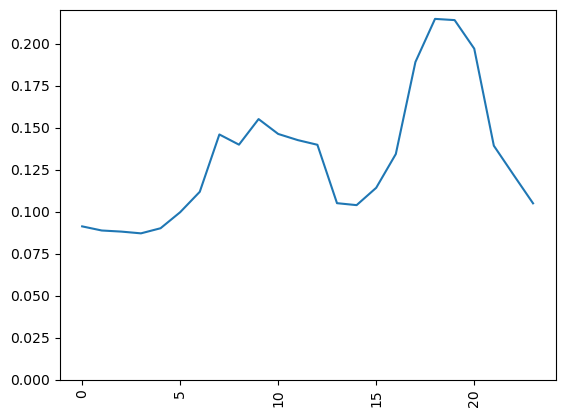

In [104]:
plt.plot(precios_enero_df)
plt.ylim(0,0.22)
plt.xticks(rotation = 90);

In [105]:
# Ya tengo el consumo para temperatura estabilizada.
# Necesito obtener el consumo para la fase de calentamiento.
# Voy a tomarlo como el consumo de la primera hora.
# Puedo hacerlo con el día de muestra,
# o buscar la instancia en que el delta era más grande a la hora de conectar.
# Luego puedo evaluar € para distintas estrategias


## Consumo en fase de calentamiento
Estudio del arranque más desfavorable del mes

In [106]:
# Consumo primera hora día de muestra

arranque_1 = caso_estudio[(caso_estudio['time'] > '2023-01-09 08:10') & (caso_estudio['time'] < '2023-01-09 09:15')]

In [107]:
arranque_1

,time,kWh.mean_value,°C.mean_value,°C.mean_value_2,€/kWh.mean_value,consumo,delta_temp,gradiente_interior
24891,2023-01-09 08:15:00+00:00,790.841667,9.566667,17.50,0.18949,0.005952,7.933333,-0.10
24892,2023-01-09 08:20:00+00:00,790.967000,9.583333,18.35,0.18949,0.125333,8.766667,0.85
24893,2023-01-09 08:25:00+00:00,791.070000,9.600000,18.35,0.18949,0.103000,8.750000,0.00
24894,2023-01-09 08:30:00+00:00,791.140000,9.675000,19.10,0.18949,0.070000,9.425000,0.75
24895,2023-01-09 08:35:00+00:00,791.235000,9.750000,19.70,0.18949,0.095000,9.950000,0.60
24896,2023-01-09 08:40:00+00:00,791.308000,9.825000,19.70,0.18949,0.073000,9.875000,0.00
24897,2023-01-09 08:45:00+00:00,791.392222,9.900000,20.20,0.18949,0.084222,10.300000,0.50
24898,2023-01-09 08:50:00+00:00,791.460000,9.975000,20.20,0.18949,0.067778,10.225000,0.00
24899,2023-01-09 08:55:00+00:00,791.542222,10.050000,20.80,0.18949,0.082222,10.750000,0.60
24900,2023-01-09 09:00:00+00:00,791.610000,10.125000,20.80,0.23316,0.067778,10.675000,0.00


In [108]:
# consumo del arranque: kWh durante 1 h
arranque_1['consumo'].sum()

0.8792857142857429

Como se observa, el arranque equivale a 3 horas de consumo con la temp estabilizada

In [109]:
# incremento de temp en este arranque
arranque_1['°C.mean_value_2'].iloc[-1] - arranque_1['°C.mean_value_2'].iloc[0]

3.6000000000000014

In [110]:
# Temperatura interior más baja:
enero[['time', '°C.mean_value_2']][enero['°C.mean_value_2'] == enero['°C.mean_value_2'].min()]

,time,°C.mean_value_2
24342,2023-01-07 10:30:00+00:00,16.1
24343,2023-01-07 10:35:00+00:00,16.1
24344,2023-01-07 10:40:00+00:00,16.1
24420,2023-01-07 17:00:00+00:00,16.1
24421,2023-01-07 17:05:00+00:00,16.1
24422,2023-01-07 17:10:00+00:00,16.1


In [111]:
# Temperatura interior más baja en un arranque
enero['°C.mean_value_2'][enero['consumo'] > 0].min()

16.1

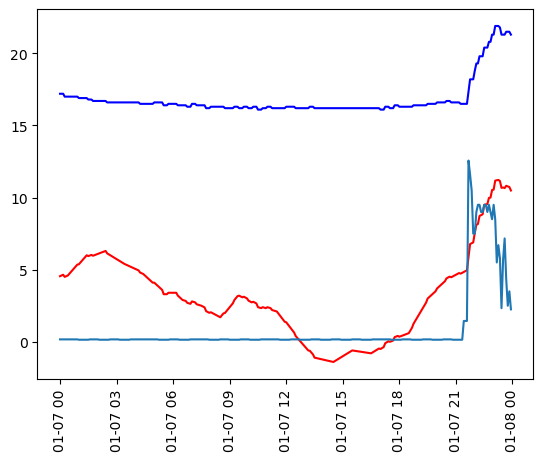

In [112]:
dia_07 = enero.copy()[enero['time'].dt.day == 7]

plt.plot(dia_07['time'], dia_07['delta_temp'], color = 'red')
plt.plot(dia_07['time'], dia_07['°C.mean_value_2'], color = 'blue')
plt.plot(dia_07['time'], dia_07['consumo']*100)
plt.xticks(rotation = 90);

In [113]:
# El día 7 contiene el arranqe más desfavorable (desde una temperatura más baja)
# Vamos a ver cuánto se consumió
dia_07['consumo'].sum()

2.5874999999999773

In [114]:
# Y cuánto subió la temperatura
dia_07['°C.mean_value_2'].max() - dia_07['°C.mean_value_2'].min()

5.799999999999997

## Consumo en fase estable

In [115]:
consumo_estable['consumo'][consumo_estable['time'] >= '2023-01-10 00:00'].mean()*12

0.39780821917807546

Resultados:
 - Un arranque típico dura una hora, y en él se consume 0.91 kWh.
 - Un arranque desfavorable dura entre 2 y 3 horas, y consume 2.5 kWh.
 - Una hora de funcionamiento estable consume 0.3 kWh si delta < 12.
 - Una hora de funcionamiento estable consume 0.4 kWh si delta > 12.
 - La velocidad de enfriamiento más desfavorable es de -2 ºC/h
 - Las horas más caras son las 18, 19 y 20. 

## Valoración de escenarios

In [123]:
# Ahora hay que plantear escenarios para ver cómo salen en €

# Escenario 1
es_1 = 2 * precios_enero[16] + 1.5 * precios_enero[17]
print('Escenario 1: ', es_1, '€')

Escenario 1:  0.5519598387096774 €


In [124]:
# Escenario 2
es_2 = 1 * precios_enero[16] + 1.5 * precios_enero[17] + 0.3 * precios_enero[21]
print('Escenario 1: ', es_2, '€')

Escenario 1:  0.4594816451612903 €


In [137]:
# Escenario 1
es_3 = 0.9 * precios_enero[16] + 0.4 * precios_enero[17] + 0.4 * precios_enero[18] + 0.4 * precios_enero[19] + 0.4 * precios_enero[20] + 0.4 * precios_enero[21] + 0.4 * precios_enero[22] + 0.4 * precios_enero[23]
print('Escenario 1: ', es_3, '€')

Escenario 1:  0.593014741935484 €


In [133]:
# groups = enero.groupby(pd.Grouper(key= 'time', freq='1D'))
# days = pd.DataFrame()

# for name, group in groups:
#     days[name.day] = group.values

# days.plot(subplots=True, legend=False)
# plt.show()

## Temperatura media en enero de 2023

In [131]:
temp_ext_enero = {}
for i in range(24):
    temp_ext_enero[i] = enero['°C.mean_value'][enero['time'].dt.hour == i].mean()
temp_ext_enero_df = pd.DataFrame.from_dict(temp_ext_enero, orient= 'index')

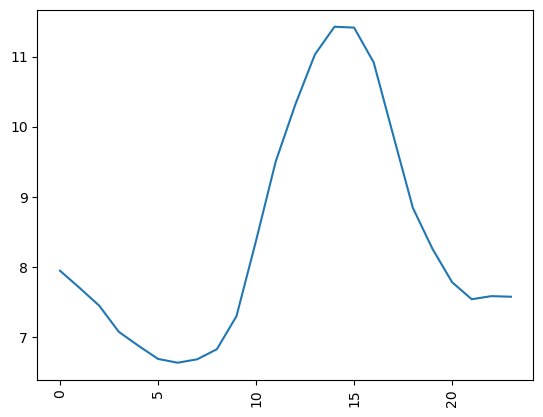

In [132]:
plt.plot(temp_ext_enero_df)
#plt.ylim(0,0.22)
plt.xticks(rotation = 90);